In [26]:
include("install_pkg.jl")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.ju

In [119]:
include("sample_sbm.jl")


Save data in .jld ? [y/n]


stdin>  y


UndefVarError: UndefVarError: I_ not defined

In [1]:
#-------------------------------------------------------------------------------
# Test the code on real data
#     In the 'Data' section, chose the name of the dataset of interest in
#   "data_name". The file must then be in data/$data_name.txt.
#   The results will then be stored in results/$data_name/$results_path/time_of_run
#     Set the parameters of the Gibbs sampler in the 'Set Parameters'
#   section. 
#-------------------------------------------------------------------------------

include("src/main.jl")

using ProgressBars
using HDF5, JLD
using DelimitedFiles
using Dates
using ProfileView
using Profile


Id = SparseArrays.I


┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/ayedm/.julia/packages/PyPlot/4wzW1/src/init.jl:192


LinearAlgebra.UniformScaling{Bool}
true*I

In [17]:
#-------------------------------------------------------------------------------
# Data
#-------------------------------------------------------------------------------
#data_name = "Email-Enron"
#data_name = "polblogs"
#data_name = "wikipedia_3000"
#data_name = "NIPS234"
#data_name = "deezer_RO_und"
#data_name = "data_for_sigma_800"
#data_name = "sbm_600"
#data_name = "sbm_1200"
data_name = "data_for_kn_medium"

# Result folder name
result_folder = "sigma 025"
result_folder = "fixed sigma 0"
# Comments about the run
comments = "Alpha free\n new update of mu tilde \n new measure unobs \n sigma max 0.25"


#-------------------------------------------------------------------------------
# Set parameters
#-------------------------------------------------------------------------------
kappa=1.;tau=5.;sigma=0.;alpha=.5;beta=alpha
warm_start = true
weighted = true
directed = true
# Are there self edges
self_edge = true

# Proportion of entries to mask
pred_ratio = 0.

# Saving clustering
save_clustering = true
# Number of clustering to save
n_clusterings = 10

n_clusterings = (save_clustering ? n_clusterings : 2)

# Set to true to display the current value of sigma every 5% of the progress. It also
# allows to save the current state of the run every 5%. Then use continue_real.jl if the script
# is stopped before the end of the sampler to carry from last save.
monitoring_sigma = true

# Number of iterations for the Gibbs sampler
n_iter = 2000
# Thinning the chain, store only every skip iteration
skip = 50
# Number of iterations as burn-in
burn = floor(Int,2*n_iter/4)
# Number of activities to store
K = 10

# Number of updates of the hyperparameters per iteration
n_steps_hyper = 20

# Hyperparameters for the MH update
prior_params = Dict()
prior_params["kappa"] = (.1,.1)
prior_params["sigma"] = (.1,.1)
prior_params["tau"] = (.1,.1)
prior_params["alpha"] = (.1,.1)
prior_params["beta"] = (1.,1.)

prop_params = Dict()
prop_params["kappa"] = 0.02
prop_params["sigma"] = 0.02
prop_params["tau"] = 0.02
prop_params["alpha"] = 0.02
prop_params["beta"] = 0.02

# Set to true if the parameter is fixed by user (to the initial value)
FIXED_KAPPA = false
FIXED_SIGMA = true
FIXED_TAU = false
FIXED_ALPHA = false
FIXED_BETA = true

true

In [18]:
#-------------------------------------------------------------------------------
# Importing data
#-------------------------------------------------------------------------------
file_name = string("data/",data_name,".txt")
println(string("Reading the file ",file_name))
@time A = readdlm(file_name,Float64)
println()

println(comments)
println()

# Convert in sparse matrix format
println("Creating sparse matrix")
i_data = [trunc(Int,x) for x in A[:,1]]
j_data = [trunc(Int,x) for x in A[:,2]]
if weighted
  val_data = [trunc(Int,x) for x in A[:,3]]
else
  val_data = ones(Int, length(i_data))
end
n = max(maximum(i_data),maximum(j_data))
sparse_data = sparse(i_data,j_data,val_data,n,n)

# If the data is undirected, keep only below diagonal
if directed==false
  for t in 1:length(i_data)
    i_ = i_data[t]
    j_ = j_data[t]
    if i_ < j_
      if weighted
        sparse_data[j_,i_] += sparse_data[i_,j_]
        sparse_data[i_,j_] = 0
      else
        sparse_data[j_,i_] = 1
        sparse_data[i_,j_] = 0
      end
    end
  end
end

# Make sure there are no self edges if self_edge is set to true
if self_edge == false
  for t in 1:length(i_data)
    i_ = i_data[t]
    j_ = j_data[t]
    if i_ == j_
      sparse_data[i_,j_] = 0
    end
  end
end

sparse_data = dropzeros(sparse_data)

println()

Reading the file data/data_for_kn_medium.txt
  0.341711 seconds (281.86 k allocations: 12.822 MiB)

Alpha free
 new update of mu tilde 
 new measure unobs 
 sigma max 0.25

Creating sparse matrix



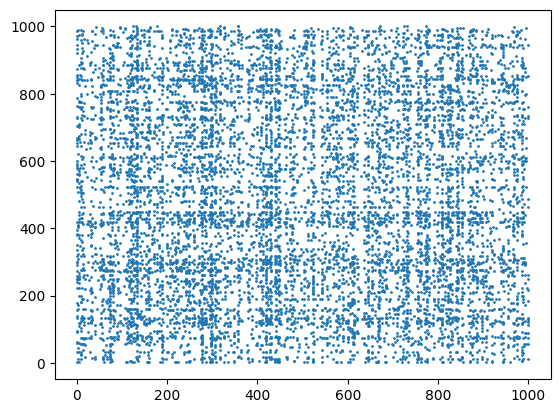

In [19]:
spy_sparse(sparse_data)

In [20]:
sum(sparse_data)

10572

In [21]:
#-------------------------------------------------------------------------------
# Save folder
#-------------------------------------------------------------------------------
# Path to the folder where to store the information
main_dir = pwd()
current_dir = Dates.format(now(),"dd-mm-yy_HH-MM-SS")

# Saving main informations about the run in a txt file
println("Saving in "*current_dir)
println()
results_path = string("results/",data_name,"/",result_folder,'/',current_dir,'/')
mkpath(results_path)
open(results_path*"info.txt","w") do f
  write(f,"Dataset:\n")
  write(f,string("  name = ", data_name,"\n"))
  write(f,string("  number of nodes = ", n,"\n"))
  write(f,string("  number of edges = ", sum(sparse_data),"\n"))
  write(f,string("  directed = ", directed,"\n"))
  write(f,string("  weighted = ", weighted,"\n\n"))

  write(f,"Initial parameters:\n")
  write(f,string("  kappa = ", kappa,"\n"))
  write(f,string("  tau = ", tau,"\n"))
  write(f,string("  sigma = ", sigma,"\n"))
  write(f,string("  alpha = ", alpha,"\n"))
  write(f,string("  beta = ", beta,"\n"))
  write(f,string("  warm_start = ", warm_start,"\n\n"))

  write(f,"Hyper parameters:\n")
  write(f,string("  kappa = ", prior_params["kappa"],"\n"))
  write(f,string("  tau = ", prior_params["tau"],"\n"))
  write(f,string("  sigma = ", prior_params["sigma"],"\n"))
  write(f,string("  alpha = ", prior_params["alpha"],"\n"))
  write(f,string("  beta = ", prior_params["beta"],"\n\n"))

  write(f,string("Number of iterations = ", n_iter*skip,"\n"))

  write(f,string("Comments : ", comments,"\n"))
end



Saving in 16-04-20_11-53-20



83

In [22]:
#-------------------------------------------------------------------------------
# Initializing parameters
#-------------------------------------------------------------------------------
n=first(size(sparse_data))

# List of the number of active communities
n_active_list = zeros(Int,n_iter)
# List of the top K activites
activities_list = zeros(n_iter,K)

# Lists of values of the parameters at each step
kappa_list = zeros(n_iter)
sigma_list = zeros(n_iter)
tau_list = zeros(n_iter)
alpha_list = zeros(n_iter)
beta_list = zeros(n_iter)

# Monitoring s_min through the run
s_min_list = zeros(n_iter)


# List of l2 errors for prediction
error_list = zeros(n_iter)
error_mean_list = zeros(n_iter)
error_mean_list_burn = zeros(n_iter)

s_min = 0.

# Initializing variables
R_ = Array{Float64,1}()
V_ = Affinity()

# Initialize clusterings variables
# Initialize index of current clustering
idx_clustering = 1
# Iterations for which we save the clustering
ind_clusterings = zeros(Int,n_clusterings)
# Save the assignation of each node to its cluster
# clusterings[i,clus_idx] = idx of cluster of node i
clusterings = zeros(Int,n,n_clusterings)

# Initialize current values of parameters
c_kappa = kappa
c_sigma = sigma
c_tau = tau
c_alpha = alpha
c_beta = beta

# Debugging variables
plot_true = false
PRINT_ = false

#-------------------------------------------------------------------------------
# Initializing variables for predictions
#-------------------------------------------------------------------------------

# Observed matrix
Z_tilde = copy(sparse_data)

# Select entries to predict
println("Masking entries to predict")
if directed
  n_to_predict = trunc(Int,pred_ratio*(n^2-n))
else
  n_to_predict = trunc(Int,pred_ratio/2*(n^2-n))
end
println("Select $n_to_predict indices to predict")

# First select more than needed entries, since we can't hide
# any entry
if directed
  n_to_predict = trunc(Int,1.15*pred_ratio*n^2)
else
  n_to_predict = trunc(Int,1.15*pred_ratio/2*n^2)
end
I_pred,J_pred = rand(1:n,n_to_predict),rand(1:n,n_to_predict)
if directed == false
  for t in 1:n_to_predict
    i_pred = I_pred[t]
    j_pred = J_pred[t]
    if i_pred > j_pred
      I_pred[t] = j_pred
      J_pred[t] = i_pred
    end
  end
end
@time to_predict = sparse(I_pred,J_pred,ones(Int64,n_to_predict),n,n)
I_pred,J_pred = findnz(to_predict)
n_to_predict = length(I_pred)
v_true = Array{Int64, n_to_predict}
is_test = zeros(Int64,n_to_predict)
println("Mask corresponding entries")
@time for t in 1:n_to_predict
  i_pred = I_pred[t]
  j_pred = J_pred[t]
  if i_pred != j_pred
    if Z_tilde[i_pred,j_pred] == 0 || ( sum(Z_tilde[i_pred,:]) > 1 && sum(Z_tilde[:,j_pred])  > 1 )
      is_test[t] = 1
      v_true[t] = sparse_data[i_pred,j_pred]
      if weighted == false
        v_true[t] = min(v_true[t],1)
      end
      Z_tilde[i_pred,j_pred] = 0
    end
  end
  if sum(is_test) > pred_ratio/2*(n^2-n) && directed == false
    break
  end
  if sum(is_test) > pred_ratio*(n^2-n)
    break
  end
end
n_to_predict = sum(is_test)
to_predict = sparse(I_pred[findall(is_test)], J_pred[findall(is_test)], ones(Int64,n_to_predict),n,n)
I_pred, J_pred = findnz(to_predict)
v_true = (n_to_predict > 0) ? v_true[findall(is_test)] : [] 
I_tilde,J_tilde,V_tilde = findnz(Z_tilde)
Z_tilde = sparse(I_tilde,J_tilde,V_tilde,n,n)
# Vecor with integer predictions
pred_vect = ones(Float64,n_to_predict)
# Vector of posterior mean
pred_average_vect = zeros(Float64,n_to_predict)
pred_average_vect_burn = zeros(Float64,n_to_predict)

# Sparse matrix of observed entries and the ones to predict
I_all,J_all,V_all = findnz(Z_tilde+to_predict+sparse(Id, n, n))
all_ind_mat = dropzeros(sparse(I_all,J_all,ones(Int,length(I_all)),n,n))
println()


if warm_start == false
  global partition_ = Factorized{Bool}()
  global sentAndReceived_ = Count()
  partition_[1] = Z_tilde
  sentAndReceived_[1] = reshape(sum(Z_tilde,dims=1),n) + reshape(sum(Z_tilde,dims=2),n)
else
  K_init = trunc(Int,active_feature_mean(n, c_kappa, c_tau, c_sigma, c_alpha, c_beta))+1
  s_min_init = Inf
  r_dist_init = Gamma(1-c_sigma,1/c_tau)
  R_ = zeros(K_init)
  for k in 1:K_init
    R_[k] = rand(r_dist_init)
    V_[k] = c_alpha/c_beta*ones(n)
    s_min_init = min(s_min_init,R_[k])
  end
  slice_matrix = s_min_init*all_ind_mat
  if weighted
    partition_,sentAndReceived_ = update_partition(R_,V_,slice_matrix,Z_tilde,to_predict,pred_vect,directed,self_edge)
  else
    partition_,sentAndReceived_ = update_partition_unweighted(R_,V_,slice_matrix,Z_tilde,to_predict,pred_vect,directed,self_edge)
  end
end



Masking entries to predict
Select 0 indices to predict
  0.000044 seconds (24 allocations: 9.156 KiB)
Mask corresponding entries
  0.000009 seconds (1 allocation: 32 bytes)



(Dict(2 => 
  [299,    1]  =  true
  [325,    1]  =  true
  [334,    1]  =  true
  [439,    1]  =  true
  [721,    1]  =  true
  [943,    1]  =  true
  [136,    5]  =  true
  [447,    5]  =  true
  [986,    5]  =  true
  [986,    6]  =  true
  [66 ,   10]  =  true
  [299,   10]  =  true
  ⋮
  [680,  987]  =  true
  [260,  989]  =  true
  [446,  989]  =  true
  [781,  989]  =  true
  [874,  990]  =  true
  [106,  992]  =  true
  [240,  992]  =  true
  [778,  992]  =  true
  [277,  993]  =  true
  [162,  995]  =  true
  [124, 1000]  =  true
  [671, 1000]  =  true
  [773, 1000]  =  true,11 => 
  [59 ,   1]  =  true
  [523,   1]  =  true
  [662,   1]  =  true
  [733,   1]  =  true
  [286,   2]  =  true
  [184,   3]  =  true
  [443,   5]  =  true
  [78 ,   6]  =  true
  [775,   6]  =  true
  [10 ,  10]  =  true
  [76 ,  10]  =  true
  [716,  10]  =  true
  ⋮
  [299, 986]  =  true
  [34 , 987]  =  true
  [187, 987]  =  true
  [411, 987]  =  true
  [446, 987]  =  true
  [513, 987]  =  true
  

In [25]:
#-------------------------------------------------------------------------------
# Starting the MCMC iterations
#-------------------------------------------------------------------------------
println(string("Starting Gibbs sample with ",n_iter," steps"))

start = time_ns()

Profile.clear()
#@showprogress for i in 1:n_iter
for i in tqdm(1:n_iter)

    #FIXED_SIGMA = (i < n_iter/4)
    
    global partition_, sentAndReceived_, all_ind_mat
    global c_kappa, c_tau, c_sigma, c_alpha, c_beta
    global n_active_list, activities_list
    global kappa_list, sigma_list, tau_list, alpha_list, beta_list
    global s_min_list, error_list, error_mean_list, error_mean_list_burn
    global pred_average_vect
    
    print(c_sigma)
    
    # Update measure
    R_,V_,n_observed,slice_matrix,s_min = update_measure(partition_,sentAndReceived_,all_ind_mat,c_kappa,c_tau,c_sigma,c_alpha,c_beta)

    # Update partition
    if weighted
      partition_,sentAndReceived_ = update_partition(R_,V_,slice_matrix,Z_tilde,to_predict,pred_vect,directed,self_edge)
    else
      partition_,sentAndReceived_ = update_partition_unweighted(R_,V_,slice_matrix,Z_tilde,to_predict,pred_vect,directed,self_edge)
    end
    # Update hyperparameters
    for t in 1:n_steps_hyper
      c_kappa,c_sigma,c_tau,c_alpha,c_beta = update_parameters_neg2(c_kappa,
                                                                  c_sigma,
                                                                  c_tau,
                                                                  c_alpha,
                                                                  c_beta,
                                                                  prior_params,
                                                                  prop_params,
                                                                  R_,
                                                                  V_,
                                                                  sentAndReceived_,
                                                                  s_min)
    end
    PRINT_ = false
    for bob in 1:(skip-1)
        # Update measure
        R_,V_,n_observed,slice_matrix,s_min = update_measure(partition_,sentAndReceived_,all_ind_mat,c_kappa,c_tau,c_sigma,c_alpha,c_beta)

        # Update partition
        if weighted
          partition_,sentAndReceived_ = update_partition(R_,V_,slice_matrix,Z_tilde,to_predict,pred_vect,directed,self_edge)
        else
          partition_,sentAndReceived_ = update_partition_unweighted(R_,V_,slice_matrix,Z_tilde,to_predict,pred_vect,directed,self_edge)
        end

        # Update hyperparameters
        for t in 1:n_steps_hyper
            c_kappa,c_sigma,c_tau,c_alpha,c_beta = update_parameters_neg2(c_kappa,
                                                                      c_sigma,
                                                                      c_tau,
                                                                      c_alpha,
                                                                      c_beta,
                                                                      prior_params,
                                                                      prop_params,
                                                                      R_,
                                                                      V_,
                                                                      sentAndReceived_,
                                                                      s_min)
        end

    end


    # Store values
    n_active_list[i] = n_observed
    sort_idx = sortperm(R_,rev=true)
    sorted_R_ = R_[sort_idx]
    for j in 1:min(n_observed,K)
      activities_list[i,j] = sorted_R_[j]*sum(V_[sort_idx[j]])
    end

    # Store clustering
    if i > burn && (i-burn)%floor(Int,(n_iter-burn)/n_clusterings) == 0 && idx_clustering <= n_clusterings
      ind_clusterings[idx_clustering] = i
      for node_idx in 1:n
        weights = [sqrt(R_[c])*V_[c][node_idx] for c in sort_idx[1:min((2*K),length(R_))]]
        clusterings[node_idx,idx_clustering] = argmax(weights)
      end
      idx_clustering += 1
    end


    pred_average_vect = (i*pred_average_vect+pred_vect)/(i+1)

    # Compute auc error (l2 error in comments)
    if n_to_predict > 0
        error_list[i] = auc_pr(pred_vect, v_true)#norm(v_true-pred_vect)
        error_mean_list[i] = auc_pr(pred_average_vect,v_true)#norm(v_true-pred_average_vect)
    end
    i_b = i-burn
    #if i_b >= 0
    #  pred_average_vect_burn = (i_b*pred_average_vect_burn+pred_vect)/(i_b+1)
    #  error_mean_list_burn[i] = auc_pr(pred_average_vect_burn,v_true)#norm(v_true-pred_average_vect)
    #end

    print_each = floor(Int,n_iter/20)
    # If monitoring sigma
    if monitoring_sigma && i%print_each == 0
      println(string("Progress: ", 100*i/n_iter,"%"))
      println(string("Current sigma: ",c_sigma))
      println(string("Length R: ",length(R_)))

      # Save Variables
      results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/variables/")
      mkpath(results_path)
      cd(results_path)

      # Store the variables
      save("variables.jld","activities_list",activities_list,
                          "n_active_list",n_active_list,
                          "kappa_list",kappa_list,
                          "sigma_list",sigma_list,
                          "tau_list",tau_list,
                          "alpha_list",alpha_list,
                          "beta_list",beta_list,
                          "partition_",partition_,
                          "sentAndReceived_",sentAndReceived_,
                          "clusterings",clusterings,
                          "ind_clusterings",ind_clusterings,
                          "n_iter",n_iter,
                          "skip",skip,
                          "prop_params",prop_params,
                          "prior_params",prior_params)
      cd(main_dir)

      #PRINT_ = true
    end

    kappa_list[i] = c_kappa
    sigma_list[i] = c_sigma
    tau_list[i] = c_tau
    alpha_list[i] = c_alpha
    beta_list[i] = c_beta

end

# Compute partition and corresponding active communities of last iteration
R_t,V_t,n_observed,slice_matrix,s_min = update_measure(partition_,sentAndReceived_,all_ind_mat,c_kappa,c_tau,c_sigma,c_alpha,c_beta)
R_ = R_t[1:n_observed]
V_ = Affinity()
for k in 1:n_observed
  V_[k] = V_t[k]
end
elapsed_time = time_ns() - start



Starting Gibbs sample with 2000 steps
5.0%┣██                                     ┫ 99/2000 [08:14<02:39:51, 0.2 it/s]0.0Progress: 5.0%
Current sigma: 0.0
Length R: 6
10.0%┣███▊                                 ┫ 199/2000 [14:48<02:14:41, 0.2 it/s]0.0Progress: 10.0%
Current sigma: 0.0
Length R: 5
14.9%┣█████▌                               ┫ 299/2000 [21:15<02:01:20, 0.2 it/s]0.0Progress: 15.0%
Current sigma: 0.0
Length R: 11
20.0%┣███████▍                             ┫ 399/2000 [27:48<01:51:50, 0.2 it/s]0.0Progress: 20.0%
Current sigma: 0.0
Length R: 10
24.9%┣█████████▎                           ┫ 499/2000 [34:22<01:43:36, 0.2 it/s]0.0Progress: 25.0%
Current sigma: 0.0
Length R: 6
29.9%┣███████████                          ┫ 599/2000 [40:50<01:35:41, 0.2 it/s]0.0Progress: 30.0%
Current sigma: 0.0
Length R: 6
34.9%┣█████████████                        ┫ 699/2000 [47:31<01:28:35, 0.2 it/s]0.0Progress: 35.0%
Current sigma: 0.0
Length R: 7
40.0%┣██████████████▉                      ┫ 799/20

0x00000764392024c2

In [262]:
ProfileView.view()

┌ Warning: There were no samples collected. Run your program longer (perhaps by
│ running it multiple times), or adjust the delay between samples with
│ `Profile.init()`.
└ @ Profile /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.3/Profile/src/Profile.jl:667


In [27]:
#-------------------------------------------------------------------------------
# Saving main variables
#-------------------------------------------------------------------------------

# Saving main informations about the run
results_path = string("results/",data_name,"/",result_folder,'/',current_dir,'/')
mkpath(results_path)
open(results_path*"info.txt","w") do f
  write(f,"Dataset:\n")
  write(f,string("  name = ", data_name,"\n"))
  write(f,string("  number of nodes = ", n,"\n"))
  write(f,string("  number of edges = ", sum(sparse_data),"\n"))
  write(f,string("  directed = ", directed,"\n"))
  write(f,string("  weighted = ", weighted,"\n\n"))

  write(f,"Initial parameters:\n")
  write(f,string("  kappa = ", kappa,"\n"))
  write(f,string("  tau = ", tau,"\n"))
  write(f,string("  sigma = ", sigma,"\n"))
  write(f,string("  alpha = ", alpha,"\n"))
  write(f,string("  beta = ", beta,"\n"))
  write(f,string("  warm_start = ", warm_start,"\n\n"))

  write(f,string("Number of iterations = ", n_iter*skip,"\n"))
  write(f,string("Time  = ", elapsed_time," s \n\n"))

  write(f,string("Comments : ", comments,"\n"))
end

results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/variables/")
mkpath(results_path)
cd(results_path)

# Store the variables
save("variables.jld","activities_list",activities_list,
                    "n_active_list",n_active_list,
                    "kappa_list",kappa_list,
                    "sigma_list",sigma_list,
                    "tau_list",tau_list,
                    "alpha_list",alpha_list,
                    "beta_list",beta_list,
                    "partition_",partition_,
                    "sentAndReceived_",sentAndReceived_,
                    "clusterings",clusterings,
                    "ind_clusterings",ind_clusterings,
                    "n_iter",n_iter,
                    "skip",skip,
                    "prop_params",prop_params,
                    "prior_params",prior_params)
cd(main_dir)

In [45]:
argmax([5,1,9,7])

3

In [46]:
@time rand(Poisson(1e-4), 100000);

  0.195940 seconds (191.59 k allocations: 10.290 MiB)


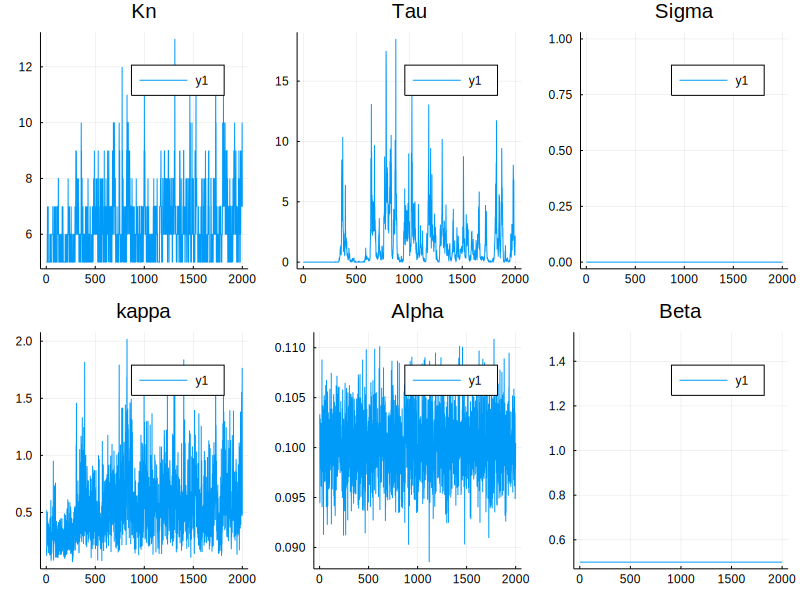

In [28]:
using Plots
T = 2000
a = Plots.plot(n_active_list[1:T], title="Kn")
b = Plots.plot(tau_list[1:T], title="Tau")
c = Plots.plot(sigma_list[1:T], title="Sigma")
d = Plots.plot(kappa_list[1:T], title="kappa")
e = Plots.plot(alpha_list[1:T], title="Alpha")
f = Plots.plot(beta_list[1:T], title="Beta")

Plots.plot(a,b,c,d,e,f, size=(800,600))

In [12]:
mean(n_active_list[1:T])

13.8105

In [67]:
final_order, clusters = cluster_communities(R_, V_)

(Any[499, 767, 686, 727, 783, 468, 135, 912, 46, 456  …  908, 108, 264, 647, 760, 911, 597, 773, 280, 676], Dict(4 => [499, 767, 686, 727, 783, 468, 135, 912, 46, 456  …  382, 202, 972, 38, 466, 281, 770, 846, 105, 78],2 => [42, 367, 386, 549, 516, 929, 551, 123, 397, 101  …  729, 184, 747, 195, 162, 777, 990, 186, 620, 344],3 => [102, 380, 275, 677, 229, 447, 57, 413, 989, 588  …  333, 199, 10, 347, 399, 204, 827, 700, 781, 18],5 => [771, 283, 918, 559, 374, 17, 607, 493, 259, 673  …  753, 92, 741, 486, 244, 825, 213, 362, 366, 724],1 => [839, 443, 943, 977, 519, 136, 525, 323, 614, 363  …  908, 108, 264, 647, 760, 911, 597, 773, 280, 676]))

In [68]:
clusters

Dict{Int64,Array{Int64,1}} with 5 entries:
  4 => [499, 767, 686, 727, 783, 468, 135, 912, 46, 456  …  382, 202, 972, 38, …
  2 => [42, 367, 386, 549, 516, 929, 551, 123, 397, 101  …  729, 184, 747, 195,…
  3 => [102, 380, 275, 677, 229, 447, 57, 413, 989, 588  …  333, 199, 10, 347, …
  5 => [771, 283, 918, 559, 374, 17, 607, 493, 259, 673  …  753, 92, 741, 486, …
  1 => [839, 443, 943, 977, 519, 136, 525, 323, 614, 363  …  908, 108, 264, 647…

In [39]:
sum(clusters[5] .< 401) / length(clusters[5])

0.77

In [201]:
ENV["PLOTS_DEFAULT_BACKEND"]

KeyError: KeyError: key "PLOTS_DEFAULT_BACKEND" not found

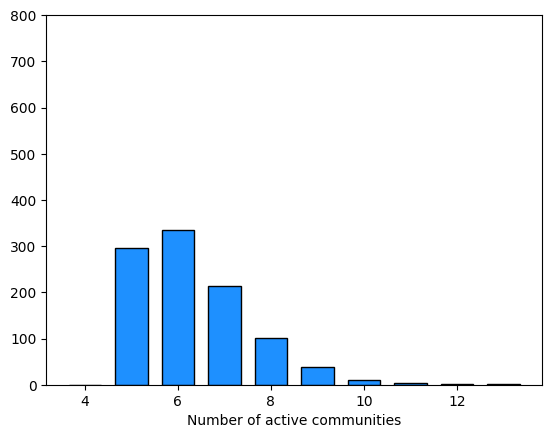

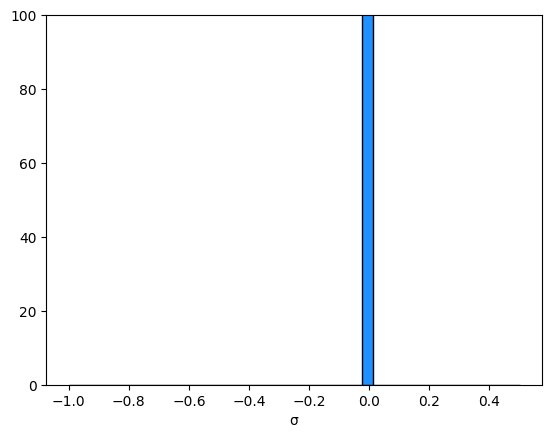

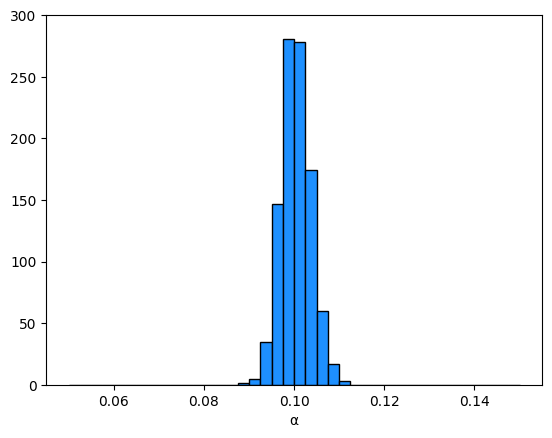

PyObject Text(0.5, 24.0, 'α')

In [30]:
# Large

PyPlot.figure(figsize=(6.40,4.80))
PyPlot.ylim((0,800))
PyPlot.hist(n_active_list[Int(T/2):T],
            range=(4,14),
            edgecolor="black",
            align="left",
            facecolor="dodgerblue",
            rwidth=0.7);
PyPlot.xlabel("Number of active communities")


PyPlot.figure(figsize=(6.40,4.80))
PyPlot.ylim((0,100))
PyPlot.hist(sigma_list[Int(T/2):T],
            range=(-1,0.5),
            bins=40,
            edgecolor="black",
            #align="left",
            facecolor="dodgerblue")
            #rwidth=0.7);
PyPlot.xlabel("σ")

PyPlot.figure(figsize=(6.40,4.80))
PyPlot.ylim((0,300))
PyPlot.hist(alpha_list[Int(T/2):T],
            range=(0.05,0.15),
            bins=40,
            edgecolor="black",
            #align="left",
            facecolor="dodgerblue")
            #rwidth=0.7);
PyPlot.xlabel("α")


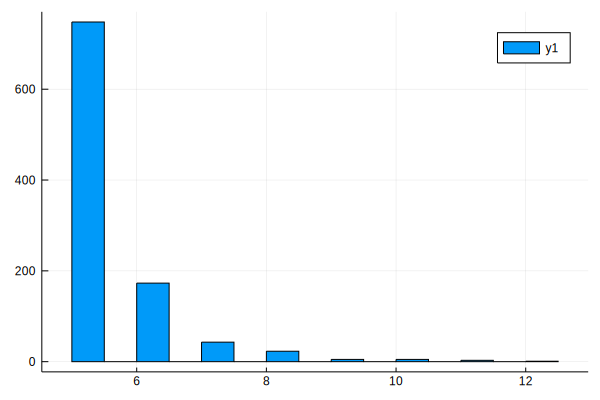

In [169]:
# Medium
Plots.histogram(n_active_list[Int(T/2):T], bins=:scott)

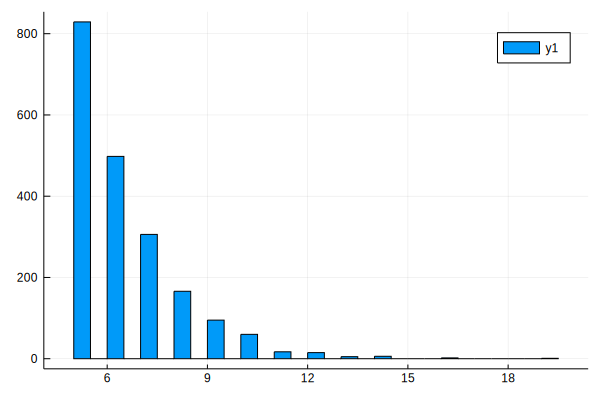

In [88]:
# Small
Plots.histogram(n_active_list[1:T])

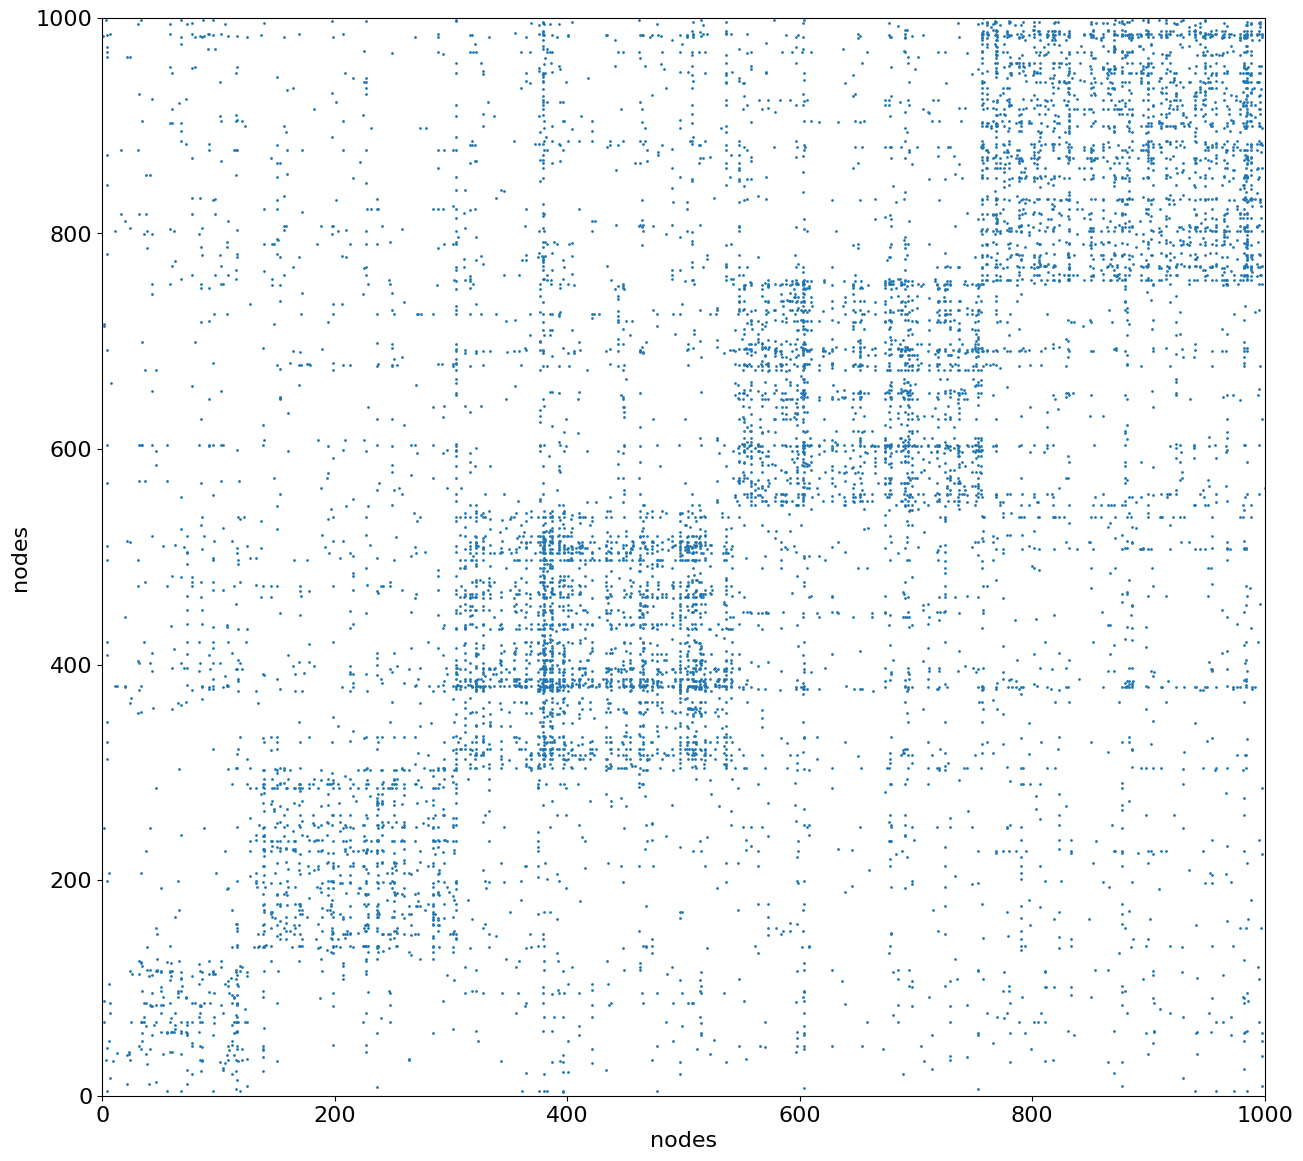

In [64]:
spy_sparse_order(sparse_data, final_order)

In [5]:
include("sample_weighted_sbm.jl")


Save data in .jld ? [y/n]


stdin>  y


In [14]:
#-------------------------------------------------------------------------------
# Saving main variables
#-------------------------------------------------------------------------------

# Saving main informations about the run
results_path = string("results/",data_name,"/",result_folder,'/',current_dir,'/')
mkpath(results_path)
open(results_path*"info.txt","w") do f
  write(f,"Dataset:\n")
  write(f,string("  name = ", data_name,"\n"))
  write(f,string("  number of nodes = ", n,"\n"))
  write(f,string("  number of edges = ", sum(sparse_data),"\n"))
  write(f,string("  directed = ", directed,"\n"))
  write(f,string("  weighted = ", weighted,"\n\n"))

  write(f,"Initial parameters:\n")
  write(f,string("  kappa = ", kappa,"\n"))
  write(f,string("  tau = ", tau,"\n"))
  write(f,string("  sigma = ", sigma,"\n"))
  write(f,string("  alpha = ", alpha,"\n"))
  write(f,string("  beta = ", beta,"\n"))
  write(f,string("  warm_start = ", warm_start,"\n\n"))

  write(f,string("Number of iterations = ", n_iter*skip,"\n"))
  write(f,string("Time  = ", elapsed_time," s \n\n"))

  write(f,string("Comments : ", comments,"\n"))
end

results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/variables/")
mkpath(results_path)
cd(results_path)

# Store the variables
save("variables.jld","activities_list",activities_list,
                    "n_active_list",n_active_list,
                    "kappa_list",kappa_list,
                    "sigma_list",sigma_list,
                    "tau_list",tau_list,
                    "alpha_list",alpha_list,
                    "beta_list",beta_list,
                    "partition_",partition_,
                    "sentAndReceived_",sentAndReceived_,
                    "clusterings",clusterings,
                    "ind_clusterings",ind_clusterings,
                    "n_iter",n_iter,
                    "skip",skip,
                    "prop_params",prop_params,
                    "prior_params",prior_params)
cd(main_dir)
# Load the data using
#   load("prediction.jld")[name of the variable]



#-------------------------------------------------------------------------------
# Save prediction
#-------------------------------------------------------------------------------
while true
  println()
  println("Save prediction vector ? [y/n]")
  continue_ = chomp(readline())
  if continue_ == "n"
    break
  end
  if continue_ == "y"
    plot_true = false
    results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/prediction/")
    mkpath(results_path)
    cd(results_path)
    save("prediction.jld","v_true",v_true,
                          "predicted",pred_average_vect,
                          "predicted_burn",pred_average_vect_burn)
    # Load the data using
    #   load("prediction.jld")["v_true"] for true values
    #   load("prediction.jld")["predicted"] for prediction without burn in
    #   load("prediction.jld")["predicted_burn"] for prediction with burn in
    break
  end
end
cd(main_dir)


#-------------------------------------------------------------------------------
# Plotting results
#-------------------------------------------------------------------------------

while true
  println()
  println("Plot and save results ? [y/n]")
  continue_ = chomp(readline())
  if continue_ == "n"
    break
  end
  if continue_ == "y"
    plot_true = false
    results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/img/")
    mkpath(results_path)
    cd(results_path)
    include(main_dir*"/src/plot_results.jl")
    break
  end
end
cd(main_dir)


#-------------------------------------------------------------------------------
# Plotting clusters
#-------------------------------------------------------------------------------
while true
  println()
  println("Plot clusters ? [y/n]")
  continue_ = chomp(readline())
  if continue_ == "n"
    break
  end
  if continue_ == "y"
    results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/img/")
    mkpath(results_path)
    cd(results_path)
    order,clusters = cluster_communities(R_,V_)
    clusters_o = zeros(n)
    for (k,cl) in clusters
      clusters_o[cl] = k
    end
    ioff()
    spy_sparse_order(sparse_data,order,2.,directed)
    spy_sparse_den(sparse_data,clusters_o)
    PyPlot.close()
    ion()
    break
  end
end
cd(main_dir)

#-------------------------------------------------------------------------------
# Saving clusters
#-------------------------------------------------------------------------------
while true
  println()
  println("Save clusters in .jld ? [y/n]")
  continue_ = chomp(readline())
  if continue_ == "n"
    break
  end
  if continue_ == "y"
    results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/clusters/")
    mkpath(results_path)
    cd(results_path)
    include("src/save_clusters.jl")
    break
  end
end
cd(main_dir)


#-------------------------------------------------------------------------------
# Saving edge allocation
#-------------------------------------------------------------------------------
order,clusters = cluster_communities(R_,V_)
while true
  println()
  println("Save edge allocation ? [y/n]")
  continue_ = chomp(readline())
  if continue_ == "n"
    break
  end
  if continue_ == "y"
    # Save partition with posterior order
    results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/img/edge_partition_/")
    mkpath(results_path)
    cd(results_path)
    ioff()
    for k in keys(partition_)
      spy_sparse_order(partition_[k],order,2.,directed,"Feature $k.png")
      PyPlot.close()
    end
    cd(main_dir)
    # Save partition with natural order
    results_path = string("results/",data_name,"/",result_folder,'/',current_dir,"/img/edge_partition/")
    mkpath(results_path)
    cd(results_path)
    for k in keys(partition_)
      spy_sparse_order(partition_[k],1:n,2.,directed,"Feature $k.png")
      PyPlot.close()
    end
    ion()
    break
  end
end
PyPlot.close("all")
cd(main_dir)


Save prediction vector ? [y/n]


stdin>  n



Plot and save results ? [y/n]


stdin>  y



Plot clusters ? [y/n]


stdin>  n



Save clusters in .jld ? [y/n]


stdin>  n



Save edge allocation ? [y/n]


stdin>  n
